(stan-reglin1-notebook)=
# Regressione logistica con Stan

In questo capitolo, approfondiremo la regressione logistica bivariata, un modello statistico che ci consente di analizzare le relazioni tra una variabile di esito binaria e una singola variabile indipendente. Esploreremo il processo di stima dei coefficienti del modello attraverso un approccio bayesiano. In aggiunta, forniremo un'interpretazione dei risultati ottenuti dalla regressione logistica. Mostreremo come i coefficienti influenzano la probabilità di successo della variabile binaria di esito, nonché come interpretare il loro segno e ampiezza. 

## Preparazione del Notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "stan_logistic_regression"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

In [6]:
def scale_columns(dataframe, columns_to_scale):
    # Work on a copy to avoid modifying the original DataFrame
    df_scaled = dataframe.copy()
    for column in columns_to_scale:
        # Scale each specified column individually
        df_scaled[column] = stats.zscore(df_scaled[column])
    return df_scaled

## Modello di Regressione Logistica per Variabili Binarie

Il modello di regressione logistica si utilizza per analizzare la relazione tra una variabile dipendente dicotomica, che assume i valori di "successo" e "fallimento", e una o più variabili indipendenti, che possono essere sia quantitative che qualitative. Consideriamo $n$ osservazioni indipendenti, dove $Y_i$ indica l'osservazione $i$-esima della variabile risposta, per $i=1, \dots, n$. Ogni osservazione è associata a un vettore di variabili esplicative $(x_1, \dots, x_p)$. La relazione che vogliamo esaminare è tra la probabilità di successo $\pi_i$ e le variabili esplicative, espressa dalla formula:

$$
P(Y=1 \mid X=x_i) = \pi_i.
$$

In questo contesto, la variabile dipendente $Y$ segue una distribuzione di Bernoulli, con i seguenti possibili valori:

$$
y_i = 
\begin{cases} 
    1 & \text{per un successo (per l'osservazione $i$-esima)},\\
    0 & \text{per un fallimento}.
\end{cases}
$$

Le probabilità associate a questi valori sono rispettivamente $\pi$ per il successo e $1-\pi$ per il fallimento:

$$
\begin{aligned}
    P(Y_i = 1) &= \pi,\\
    P(Y_i = 0) &= 1-\pi.
\end{aligned}
$$

Questo modello permette quindi di studiare come le variabili esplicative influenzino la probabilità di un evento binario, quali il successo o il fallimento.

Per illustrare, consideriamo un dataset di 100 volontari, dove `age` è la variabile esplicativa e `chd` è la variabile risposta che indica la presenza (`chd` = 1) o assenza (`chd` = 0) di disturbi cardiaci. La media condizionata $\mathbb{E}(Y \mid X=x)$ in una popolazione può essere vista come la proporzione di valori 1 per un dato punteggio $x$ sulla variabile esplicativa (ad esempio, l'età), ovvero la probabilità condizionata $\pi_i$ di osservare la presenza di sintomi cardiaci in un certo gruppo d'età:

$$
\pi_i \equiv P(Y = 1 \mid X = x).
$$

Il valore atteso diventa:

$$
\mathbb{E}(Y \mid x) = \pi_i.
$$

Se $X$ è una variabile discreta, possiamo calcolare la proporzione di $Y=1$ per ogni valore di $X=x$ nel campione. Queste proporzioni rappresentano una stima non parametrica della funzione di regressione di $Y$ su $X$, e possono essere stimate tramite tecniche di smoothing.

Per valori bassi della variabile $X$ la proporzione condizionata di valori $Y=1$ è prossima allo 0. Per valori alti della $X$ la proporzione di valori $Y=1$ è prossima a 1.0. A livelli di età intermedi, la curva di regressione non parametrica gradualmente approssima i valori 0 e 1 seguendo un andamento sigmoidale. 

Anche se la regressione non parametrica produce un risultato sensato, è utile rappresentare la dipendenza di $Y$ da $X$ con una semplice funzione, in particolare quando ci sono molteplici variabili esplicative.

## Modello Lineare nelle Probabilità

Introduciamo un modello lineare con le seguenti assunzioni standard:

$$
Y_i = \alpha + \beta X_i + \varepsilon_i,
$$

dove $\varepsilon_i$ segue una distribuzione normale con media 0 e varianza 1 ($\varepsilon_i \sim \mathcal{N}(0, 1)$) e gli errori $\varepsilon_i$ e $\varepsilon_j$ sono indipendenti per ogni $i \neq j$. Il valore atteso di $Y_i$ è quindi $\mathbb{E}(Y_i) = \alpha + \beta X_i$, portando a:

$$
\pi_i = \alpha + \beta X_i.
$$

Questo è noto come *modello lineare nelle probabilità* (*linear probability model*). Tuttavia, questo approccio presenta una limitazione significativa: non garantisce che i valori predetti di $\pi_i$ siano confinati nell'intervallo [0,1], come richiesto per le probabilità.

### Problemi di Normalità

Considerando che $Y_i$ può assumere solo i valori 0 o 1, i residui $\varepsilon_i$ risultano anch'essi dicotomici e quindi non possono seguire una distribuzione normale. Ad esempio, se $Y_i=1$ con probabilità $\pi_i$, il residuo sarà:

$$
\varepsilon_i = 1 - \mathbb{E}(Y_i) = 1 - (\alpha + \beta X_i) = 1 - \pi_i.
$$

Se, invece, $Y_i=0$ con probabilità $1-\pi_i$, il residuo sarà:

$$
\varepsilon_i = 0 - \mathbb{E}(Y_i) = 0 - (\alpha + \beta X_i) = - \pi_i.
$$

Tuttavia, se la dimensione del campione è grande, il teorema del limite centrale può mitigare l'importanza dell'assunzione di normalità per le stime dei minimi quadrati.

### Problematiche di Omoschedasticità

Utilizzare il metodo dei minimi quadrati può essere inappropriato in questo contesto poiché la varianza dei residui non è costante ma dipende dalla media, e quindi dalla variabile $X$. Assumendo che il modello sia lineare, abbiamo che $\mathbb{E}(\varepsilon_i)=0$. Sfruttando le relazioni discusse in precedenza, la varianza dei residui si calcola come:

$$
\mathbb{V}(\varepsilon_i) = (1-\pi_i)\pi_i.
$$

Consideriamo che la varianza dei residui $\varepsilon_i$ può essere espressa come:

$$
\text{Var}(\varepsilon_i) = \mathbb{E}(\varepsilon_i^2) - \mathbb{E}(\varepsilon_i)^2,
$$

dove $\mathbb{E}(\varepsilon_i^2)$ è il valore atteso del quadrato dei residui e $\mathbb{E}(\varepsilon_i)^2$ è il quadrato del valore atteso dei residui.

Ora calcoliamo $\mathbb{E}(\varepsilon_i^2)$:

$$
\begin{align*}
\mathbb{E}(\varepsilon_i^2) &= \mathbb{E}[(Y_i - \mathbb{E}(Y_i))^2] \\
&= \mathbb{E}[(Y_i - \pi_i)^2] \\
&= \mathbb{E}[(Y_i^2 - 2Y_i\pi_i + \pi_i^2)] \\
&= \mathbb{E}(Y_i^2) - 2\mathbb{E}(Y_i\pi_i) + \mathbb{E}(\pi_i^2) \\
&= \mathbb{E}(Y_i) - 2\mathbb{E}(Y_i\pi_i) + \pi_i^2 \\
&= \pi_i - 2\pi_i^2 + \pi_i^2 \\
&= \pi_i - \pi_i^2 \\
&= \pi_i(1 - \pi_i)
\end{align*}
$$

Ora calcoliamo $\mathbb{E}(\varepsilon_i)^2$:

$$
\begin{align*}
\mathbb{E}(\varepsilon_i)^2 &= (\mathbb{E}(Y_i - \mathbb{E}(Y_i)))^2 \\
&= (\mathbb{E}(Y_i - \pi_i))^2 \\
&= (0)^2 \\
&= 0
\end{align*}
$$

Quindi, sostituendo questi risultati nella formula della varianza dei residui, otteniamo:

$$
\text{Var}(\varepsilon_i) = \mathbb{E}(\varepsilon_i^2) - \mathbb{E}(\varepsilon_i)^2 = \pi_i(1 - \pi_i)
$$

Quindi, abbiamo dimostrato che la varianza dei residui nella regressione logistica può essere espressa come $(1-\pi_i)\pi_i$.

Dato che $\pi_i$ dipende da $x$, ciò significa che la varianza non è costante in funzione di $x$. Questa eteroschedasticità dei residui rappresenta un problema per le stime dei minimi quadrati nel modello lineare, specialmente quando le probabilità $\pi_i$ sono vicine a 0 o 1.

### Linearità

Il maggiore inconveniente connesso all'adozione del modello lineare nelle probabilità deriva dal fatto che la stima della probabilità di successo, $P(\hat{Y}_i=1)=\hat{\pi}_i$, non è necessariamente compresa nell'intervallo ($0,1$), ma può essere sia negativa sia maggiore di 1. Nel caso dell'esempio in discussione, ciò significa che la retta dei minimi quadrati produce valori attesi $\hat{\pi}$ inferiori a 0 per bassi valori della variabile età e valori $\hat{\pi}$ superiori a 1 per valori di età alti.

## Modello Lineare nelle Probabilità Vincolato

Una soluzione per mantenere $\pi$ all'interno dell'intervallo (0, 1) è la seguente specificazione del modello:

$$
\pi=
\begin{cases}
  0                           &\text{se $\alpha + \beta X < 0$},\\
  \alpha + \beta X           &\text{se $0 \leq \alpha + \beta X \leq 1$},\\
  1 &\text{se $\alpha + \beta X > 1$}.
\end{cases}
$$

Questo *modello lineare nelle probabilità vincolato* mostra alcune instabilità, soprattutto a causa della sua dipendenza critica dai valori estremi di $\pi$, dove assume i valori 0 o 1. La linearità di $\pi = \alpha + \beta X$ si basa fortemente sui punti in cui si verificano questi estremi. In particolare, la stima di $\pi = 0$ può essere influenzata dal valore minimo di $X$ associato a $Y=1$, mentre la stima di $\pi = 1$ può dipendere dal valore massimo di $X$ per cui $Y=0$. Questi valori estremi tendono a variare significativamente tra diversi campioni e possono diventare più estremi all'aumentare della dimensione del campione.

La presenza di più variabili esplicative ($k \geq 2$) complica ulteriormente la stima dei parametri del modello. Inoltre, il modello mostra un cambiamento brusco nella pendenza della curva di regressione ai punti estremi (0 e 1 di $\pi$), risultando poco realistico in molte situazioni pratiche. Questo rende il modello meno adatto a descrivere relazioni complesse e gradualmente variabili tra $\pi$ e $X$.

Una funzione che modella una relazione più fluida e continua tra $\pi$ e $X$ sarebbe più realistica e rappresentativa delle dinamiche osservate. Questo motiva la preferenza per modelli alternativi, come il modello di regressione logistica, che tende a fornire una rappresentazione più accurata e realistica delle interazioni tra variabili dicotomiche e esplicative.

## Regressione Logistica

Un metodo efficace per gestire il problema del vincolo sulle probabilità è specificare modelli non direttamente per le probabilità stesse, ma per una loro trasformazione che elimina tale vincolo. Invece di definire un modello lineare per la probabilità condizionata $\pi_i$, si può specificare un modello lineare per il logaritmo degli odds (logit):

$$
\eta_i = \log_e \frac{\pi_i}{1-\pi_i} = \alpha + \beta x_i,
$$

Questo approccio non presenta problemi poiché il logit $\eta$ è sempre un numero reale, permettendo di modellare una trasformazione lineare di $\pi$. 

## Probabilità, Odds e Logit

La relazione tra probabilità, odds e logit viene illustrata nella tabella qui sotto. È importante notare che gli odds e il logit trasformano l'intervallo di probabilità (0, 1) in uno spettro più ampio. Gli odds rappresentano il rapporto tra la probabilità di un evento e la probabilità del suo complemento. Il logit, invece, è il logaritmo naturale degli odds, trasformando così l'intervallo di probabilità in tutta la linea dei numeri reali. Quando la probabilità è 0.5, gli odds sono 1 e il logit è 0. Logit negativi indicano probabilità inferiori a 0.5, mentre logit positivi indicano probabilità superiori a 0.5.

| Probabilità (P) | Odds (O)          | logit (L)         |
|-----------------|-------------------|-------------------|
| 0.01            | 0.01 / 0.99 = 0.0101 | $\ln(\frac{0.01}{0.99}) = -4.60$  |
| 0.05            | 0.05 / 0.95 = 0.0526 | $\ln(\frac{0.05}{0.95}) = -2.94$  |
| 0.10            | 0.10 / 0.90 = 0.1111 | $\ln(\frac{0.10}{0.90}) = -2.20$  |
| 0.30            | 0.30 / 0.70 = 0.4286 | $\ln(\frac{0.30}{0.70}) = -0.85$  |
| 0.50            | 0.50 / 0.50 = 1      | $\ln(\frac{0.50}{0.50}) = 0.00$   |
| 0.70            | 0.70 / 0.30 = 2.3333 | $\ln(\frac{0.70}{0.30}) = 0.85$   |
| 0.90            | 0.90 / 0.10 = 9      | $\ln(\frac{0.90}{0.10}) = 2.20$   |
| 0.95            | 0.95 / 0.05 = 19     | $\ln(\frac{0.95}{0.05}) = 2.94$   |
| 0.99            | 0.99 / 0.01 = 99     | $\ln(\frac{0.99}{0.01}) = 4.60$   |

### Trasformazione Inversa del Logit

La trasformazione inversa del logit, detta *antilogit*, consente di trasformare i logit in probabilità:

$$
  \pi_i =\frac{e^{\eta_i}}{1+e^{\eta_i}}.
$$ 

Logit e probabilità possono dunque essere trasformati gli uni nelle altre. La trasformazione inversa del logit consente di specificare un modello non lineare per le probabilità $\pi_i$. Tale modello non lineare è detto *logit*, o modello di regressione logistica:

$$
  \pi_i = \frac{e^{\eta_i}}{1+e^{\eta_i}} =  \frac{e^{\alpha + \beta x_i}}{1+e^{\alpha + \beta x_i}}.
$$

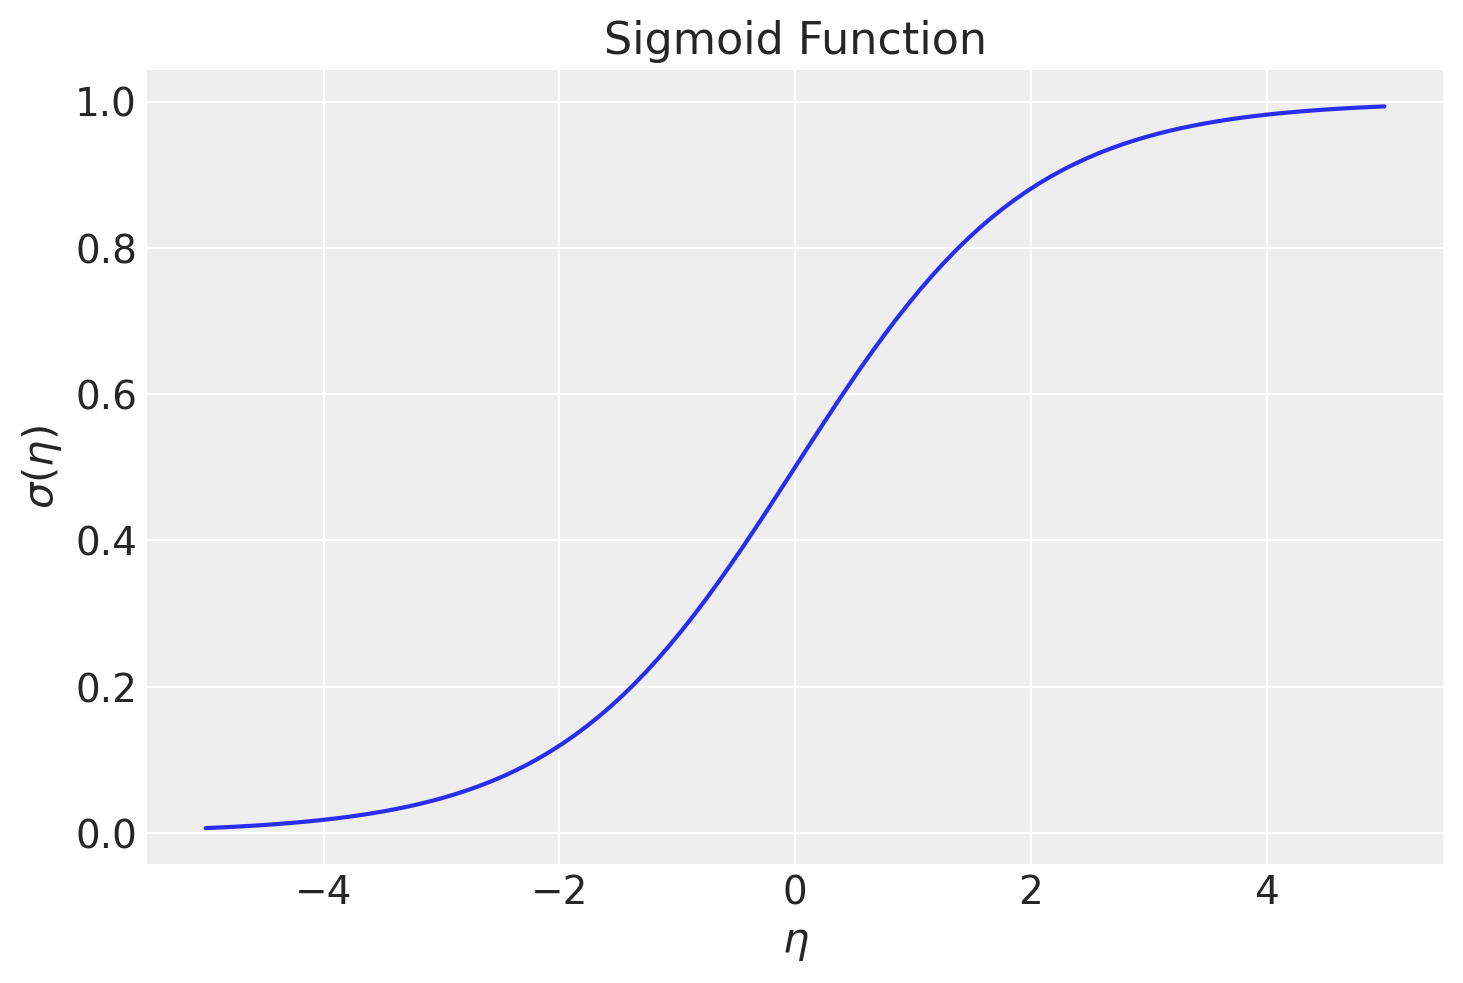

In [5]:
# Define the range for z
z = np.linspace(-5, 5, 100)

# Plot the sigmoid function
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\sigma(\eta)$")  
plt.title("Sigmoid Function")
plt.grid(True)
plt.show()

La funzione logistica ben rappresenta l'andamento sigmoidale delle proporzioni di casi $Y=1$, ovvero $\hat{\pi}_i = E(Y \mid x_i)$ in funzione di livelli crescenti della variabile $X$.

## Modelli Lineari Generalizzati 

Nel caso di una variabile risposta binaria, il modello classico di regressione lineare si scontra con sfide specifiche:

1. **Distribuzione Binomiale**: $Y_i$ segue una distribuzione binomiale (con indice $n_i$, potenzialmente uguale a uno nel caso individuale), rendendo non applicabile l'ipotesi di normalità.
2. **Limiti delle Probabilità**: Utilizzando una specificazione lineare come $\pi_i= \beta_0 + \beta_1 x_i$, si possono ottenere stime di probabilità esterne all'intervallo 0-1.
3. **Varianze Non Costanti**: La varianza di $\varepsilon$ varia in base alla specificazione del modello di probabilità, seguendo la formula $V(\varepsilon_i)=\pi_i(1-\pi_i)$.

Per superare queste sfide, si utilizzano i Modelli Lineari Generalizzati (GLM). Questi modelli consentono l'uso di variabili risposta di diversa natura e includono:

- **Regressione Lineare**: Per variabili dipendenti continue e variabili esplicative continue o qualitative.
- **Regressione Logistica**: Per variabili risposta binarie.
- **Modello Loglineare di Poisson**: Per modellare frequenze in tabelle di contingenza.

I GLM allentano alcune ipotesi fondamentali del modello lineare classico, come linearità, normalità della componente erratica, e omoschedasticità delle osservazioni. Sono strutturati in tre componenti principali:

1. **Componente Aleatoria**: Definisce la distribuzione di probabilità della variabile risposta $Y$.
2. **Componente Sistematica**: Specifica la relazione lineare tra le variabili esplicative e una trasformazione della variabile risposta.
3. **Funzione Legame**: Trasforma la media attesa $\mathbb{E}(Y)$ in un formato che possa essere modellato linearmente rispetto alle variabili esplicative. Non è la variabile risposta stessa ad essere modellizzata direttamente, ma una sua trasformazione, come il logit nel caso della regressione logistica.

Esempi di combinazioni di componenti aleatorie, funzioni di legame e sistematiche nei GLM includono:

| Componente Aleatoria | Funzione Legame | Componente Sistematica | Modello                |
|----------------------|-----------------|------------------------|------------------------|
| Gaussiana            | Identità        | Continua               | Regressione            |
| Gaussiana            | Identità        | Categoriale            | Analisi della varianza |
| Gaussiana            | Identità        | Mista                  | Analisi della covarianza |
| Binomiale            | Logit           | Mista                  | Regressione logistica  |
| Poisson              | Logaritmo       | Mista                  | Modello Loglineare     |

Questa struttura rende i GLM particolarmente flessibili e adatti a una vasta gamma di situazioni statistiche, superando i limiti del modello lineare classico.

## Componente Sistematica

La componente sistematica mette in relazione un vettore ($\eta_1, \eta_2, \dots, \eta_k$) con le variabili esplicative mediante un modello lineare. Sia $X_{ij}$ il valore della $j$-esima variabile esplicativa ($j=1, 2, \dots, p$) per l'$i$-esima osservazione ($i=1, \dots, k$). Allora 

$$
\eta_i = \sum_j \beta_j X_{ij}.
$$

Questa combinazione lineare di variabili esplicative è chiamata il *predittore lineare*. Un $X_{ij}=1, \forall i$ viene utilizzato per il coefficiente dell'intercetta del modello (talvolta denotata da $\alpha$).

## Componente Aleatoria

La  componente aleatoria del modello suppone l'esistenza di
  $k$ osservazioni indipendenti $y_1, y_2, \dots, y_k$, ciascuna delle
  quali viene trattata come la realizzazione di una variabile casuale
  $Y_i$. Si assume che $Y_i$ abbia una distribuzione binomiale:

$$
Y_i \sim Bin(n_i, \pi_i)
$$

con parametri $n_i$ e $\pi_i$. Per dati individuali (uno per ciascun valore $x_i$), $n_i=1,
    \forall i$.
  
## Funzione Legame

La  funzione legame $g(\cdot)$  mette in relazione il valore atteso della variabile risposta $Y_i$ con la componente sistematica $\eta_i$ del modello. Abbiamo visto che $\mathbb{E}(Y_i)=\pi_i$.
Che relazione c'è tra $\pi_i$ e il predittore lineare $\eta_i= \alpha + \sum_j  \beta_j X_{ij}$? 
La risposta a questa domanda è data dalla funzione legame:

$$
\eta_i = g(\pi_i) = \ln{\frac{\pi_i}{1-\pi_i}}
$$

Si noti che la funzione legame non trasforma la variabile risposta $Y_i$ ma bensì il suo valore atteso $\pi_i$.

La funzione legame è invertibile: anziché trasformare il valore atteso nel predittore lineare si può trasformare il predittore lineare nel valore atteso $\pi_i$:

$$
\pi_i = \frac{e^{\eta_i}}{1+e^{\eta_i}} =  \frac{e^{\alpha + \sum_j  \beta_j X_{ij}}}{1+e^{\alpha + \sum_j  \beta_j X_{ij}}}.
$$

Si ottiene così un modello non lineare per le probabilità $\pi_i$.

In conclusione, la regressione logistica estende il concetto di regressione lineare per modellare le probabilità condizionate di esiti Bernoulliani $ Y $, adoperando la funzione logistica come collegamento per trasformare relazioni lineari tra predittori ($ \eta_i = \beta_0 + \beta_1 X_{i} $) in probabilità nell'intervallo [0,1]. Questo metodo permette di passare dalla modellazione diretta della probabilità $ p $ alla modellazione di una funzione di tale probabilità attraverso una relazione lineare, impiegando la funzione logit come funzione di collegamento.

### Coefficienti del Modello nella Regressione Logistica e la loro Interpretazione

Un aspetto cruciale per comprendere la relazione tra le variabili predittive e una variabile di risposta binaria è l'interpretazione dei coefficienti del modello.

#### Interpretazione sui Logit

Nella regressione logistica, ogni coefficiente $\beta_j$ del modello può essere interpretato direttamente in termini di log-odds, che sono i logaritmi delle probabilità di ottenere un evento con esito positivo ($y=1$). Quando interpretiamo i coefficienti:

- **Coefficienti Positivi ($\beta_j > 0$):** Un coefficiente positivo indica che c'è una relazione diretta tra il predittore e l'aumento dei log-odds di osservare l'evento di interesse. Questo significa che all'aumentare del valore del predittore, la probabilità dell'evento di interesse aumenta proporzionalmente. In altre parole, un aumento unitario nel valore del predittore porta a un aumento proporzionale dei log-odds e quindi della probabilità dell'evento.
  
- **Coefficienti Negativi ($\beta_j < 0$):** Al contrario, un coefficiente negativo indica una relazione inversa tra il predittore e la probabilità logistica dell'evento. Con l'aumentare del predittore, i log-odds e quindi la probabilità dell'evento diminuiscono. In altre parole, un aumento unitario nel valore del predittore porta a una diminuzione proporzionale dei log-odds e quindi della probabilità dell'evento.

Quindi, quando un coefficiente $\beta_j$ è positivo, l'effetto del predittore sul log-odds (e quindi sulla probabilità) è moltiplicativo, poiché un aumento nel valore del predittore moltiplica i log-odds proporzionalmente. Al contrario, quando un coefficiente $\beta_j$ è negativo, l'effetto del predittore è ancora moltiplicativo, ma porta a una diminuzione proporzionale dei log-odds e quindi della probabilità dell'evento.

#### Interpretazione sugli Odds Ratio (OR)

L'interpretazione dei coefficienti nella regressione logistica può estendersi agli odds ratio (OR), che forniscono informazioni sulla relazione tra i predittori e la probabilità dell'evento di interesse. Per esempio, consideriamo un modello con un predittore binario $X$ e un coefficiente $\beta_1 = 0.50$. Il logaritmo naturale dell'odds ratio, $\log(OR) = 0.50$, viene esponenziato per ottenere:

$$
OR = e^{0.50} \approx 1.65.
$$

Questo risultato indica che per un individuo nel gruppo con $X = 1$, l'odds di sperimentare l'evento di interesse è circa 1.65 volte maggiore rispetto a un individuo nel gruppo con $X = 0$. In altre parole, la presenza del predittore $X$ aumenta l'odds di sperimentare l'evento di interesse di circa il 65%. Viceversa, un coefficiente negativo indicherebbe una diminuzione dell'odds per il gruppo con $X = 1$.

#### Interpretazione sulla Scala delle Probabilità

La regressione logistica consente di interpretare i coefficienti non solo in termini di log-odds, ma anche relativamente alle variazioni di probabilità. Consideriamo un modello che predice la probabilità di superare un esame basandosi sul numero di ore di studio ($X$).

Supponiamo che il coefficiente associato alle ore di studio sia $\beta_1 = 0.5$. Questo valore indica che ogni ora aggiuntiva di studio incrementa i log-odds di successo nell'esame. Per comprendere l'impatto di un'ora in più di studio sulla probabilità di successo, possiamo utilizzare la seguente formula:

$$
\Delta p = \frac{1}{1 + e^{-(\beta_0 + 0.5 \cdot (X_1 + 1))}} - \frac{1}{1 + e^{-(\beta_0 + 0.5 \cdot X_1)}}
$$

Questa formula calcola la differenza tra la probabilità di successo dopo aver aggiunto un'ora di studio e la probabilità di successo prima di tale aggiunta. In termini pratici, $\Delta p$ rappresenta l'incremento della probabilità di superare l'esame attribuibile a un'ora supplementare di studio. Questa interpretazione è cruciale per valutare quantitativamente l'effetto delle ore di studio sulla probabilità di superare l'esame.

## Un esempio concreto

In questo tutorial, utilizzeremo un set di dati forniti dal sito di Bambi per illustrare il modello di regressione logistica. Questi dati provengono da uno studio pilota del 2016. L'intero studio comprendeva un campione di 1200 individui, ma per questo tutorial, è stato selezionato un sottoinsieme di 487 partecipanti che hanno risposto a una specifica domanda riguardante la loro intenzione di voto tra Hillary Clinton e Donald Trump.

Importiamo i dati.

In [8]:
clinton_data = pd.read_csv("../data/clinton.csv")
clinton_data.dropna(inplace=True)
clinton_data = clinton_data.query("vote != 'someone_else'")
clinton_data.head()

,Unnamed: 0,vote,age,party_id
0,0,clinton,56,democrat
1,1,trump,65,republican
2,2,clinton,80,democrat
3,3,trump,38,republican
4,4,trump,60,republican


La nostra variabile di esito è `vote`, che indica le risposte delle persone alla seguente domanda:

> If the 2016 presidential election were between Hillary Clinton for the Democrats and Donald Trump for the Republicans, would you vote for Hillary Clinton, Donald Trump, someone else, or probably not vote?

In [9]:
# Conversione dei valori nella colonna 'vote'
clinton_data['vote'] = clinton_data['vote'].replace({'clinton': 1, 'trump': 0})
clinton_data['vote'] = clinton_data['vote'].astype(int)
clinton_data.head()

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_50420/1878734763.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinton_data['vote'] = clinton_data['vote'].replace({'clinton': 1, 'trump': 0})


,Unnamed: 0,vote,age,party_id
0,0,1,56,democrat
1,1,0,65,republican
2,2,1,80,democrat
3,3,0,38,republican
4,4,0,60,republican


Esaminiamo la distribuzione di frequenze della variabile `vote`.

In [22]:
clinton_data["vote"].value_counts()

vote
1    215
0    158
Name: count, dtype: int64

In [23]:
columns_to_scale = ['age']
scaled_df = scale_columns(clinton_data, columns_to_scale)
scaled_df.head()

,Unnamed: 0,vote,age,party_id
0,0,1,0.392692,democrat
1,1,0,0.916229,republican
2,2,1,1.788790,democrat
3,3,0,-0.654382,republican
4,4,0,0.625375,republican


In [24]:
scaled_df['vote'] = pd.to_numeric(scaled_df['vote'], errors='coerce')
data_matrix = scaled_df[['vote']]
data_matrix.shape

(373, 1)

In [25]:
stan_data = {
    "N" : data_matrix.shape[0],
    "y" : scaled_df['vote'].astype(int),
    "x" : scaled_df["age"] 
}

In [26]:
stan_file = os.path.join('stan', 'logistic_regression.stan')
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> N;
  vector[N] x;
  array[N] int<lower=0, upper=1> y;
}
parameters {
  real alpha;
  real beta;
}
model {
  y ~ bernoulli_logit(alpha + beta * x);
}



In [27]:
model = CmdStanModel(stan_file=stan_file)

In [28]:
fit = model.sample(data=stan_data)

07:53:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:53:51 - cmdstanpy - INFO - CmdStan done processing.


In [29]:
az.summary(fit, var_names=(["alpha", "beta"]), hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.316,0.108,0.106,0.519,0.002,0.001,3531.0,2773.0,1.0
beta,-0.312,0.107,-0.532,-0.117,0.002,0.001,3879.0,2990.0,1.0


In [30]:
new_data = pd.DataFrame({
    "age": np.linspace(18, 90, 100)
})
new_data

,age
0,18.000000
1,18.727273
2,19.454545
3,20.181818
4,20.909091
...,...
95,87.090909
96,87.818182
97,88.545455
98,89.272727


In [31]:
alpha = fit.stan_variable('alpha').mean()
beta = fit.stan_variable('beta').mean() 

In [32]:
beta

-0.31171371942825

In [33]:
# Calcola le probabilità logit per ogni età in `new_data`
logit_p = alpha + new_data['age'] * beta
logit_p

0     -5.294879
1     -5.521580
2     -5.748281
3     -5.974982
4     -6.201683
        ...    
95   -26.831464
96   -27.058164
97   -27.284865
98   -27.511566
99   -27.738267
Name: age, Length: 100, dtype: float64

In [34]:
new_data['logit_p'] = logit_p

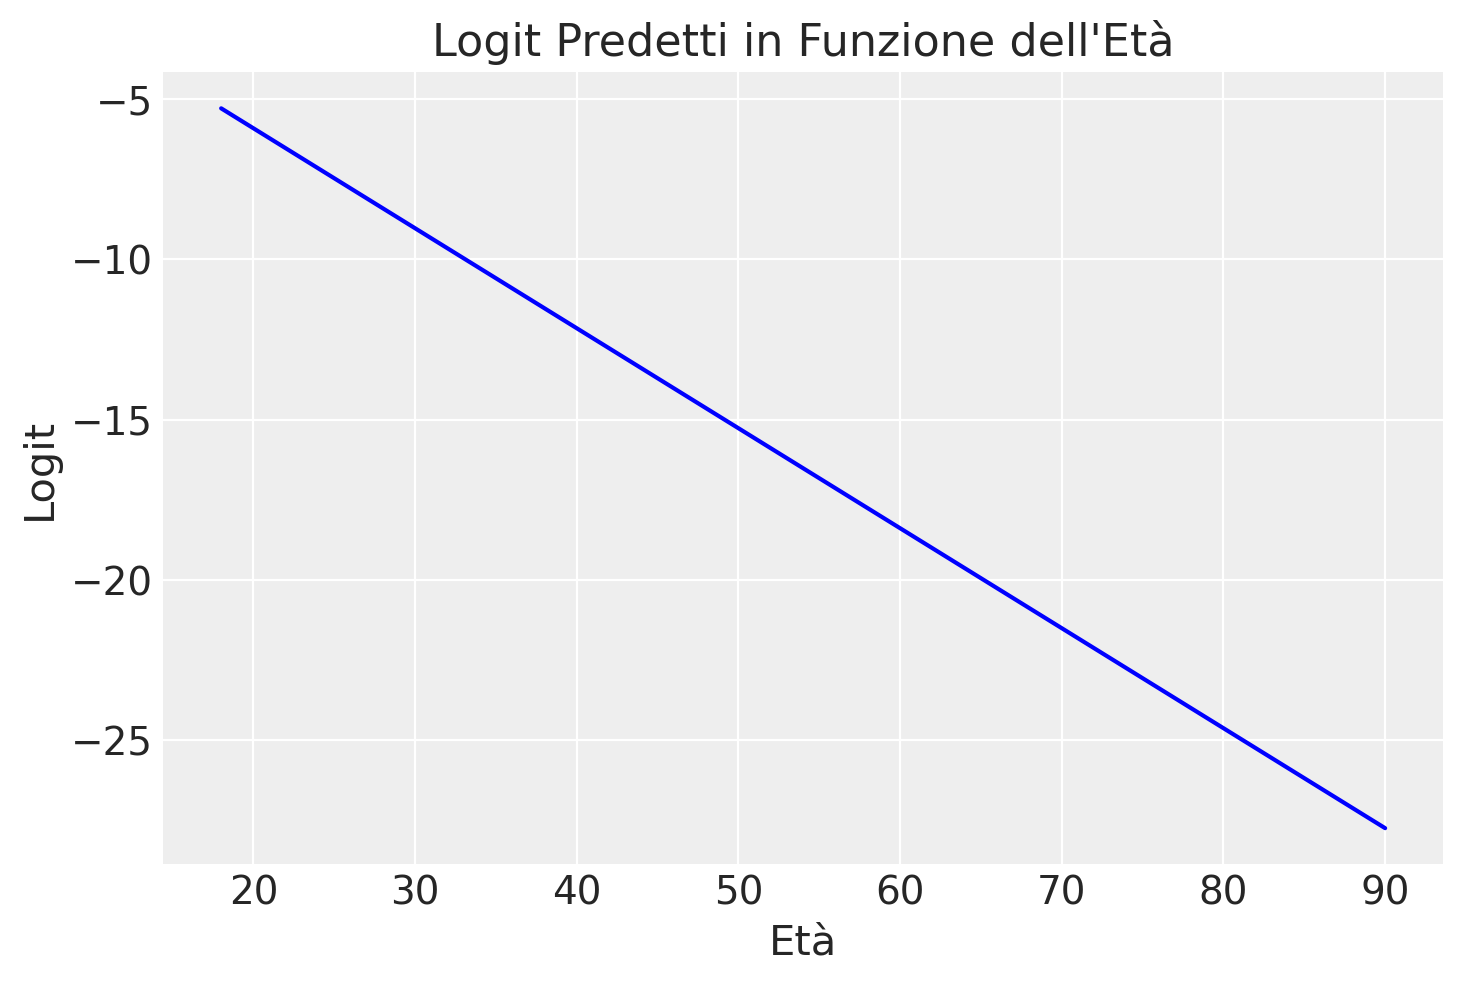

In [35]:
plt.plot(new_data['age'], new_data['logit_p'], linestyle='-', color='blue')  # Plot con marcatori e linea

plt.title('Logit Predetti in Funzione dell\'Età')  # Titolo del grafico
plt.xlabel('Età')  # Etichetta asse x
plt.ylabel('Logit')  # Etichetta asse y
plt.show() 

In [36]:
# Converti logit in probabilità usando la funzione logistica (expit)
prob = expit(logit_p)
# Aggiungi le probabilità calcolate a `new_data`
new_data['prob'] = prob

In [37]:
new_data.describe()

,age,logit_p,prob
count,100.000000,100.000000,1.000000e+02
mean,54.000000,-16.516573,2.466597e-04
std,21.099267,6.576931,7.943007e-04
min,18.000000,-27.738267,8.983046e-13
25%,36.000000,-22.127420,2.467153e-10
50%,54.000000,-16.516573,6.756587e-08
75%,72.000000,-10.905726,1.844443e-05
max,90.000000,-5.294879,4.992173e-03


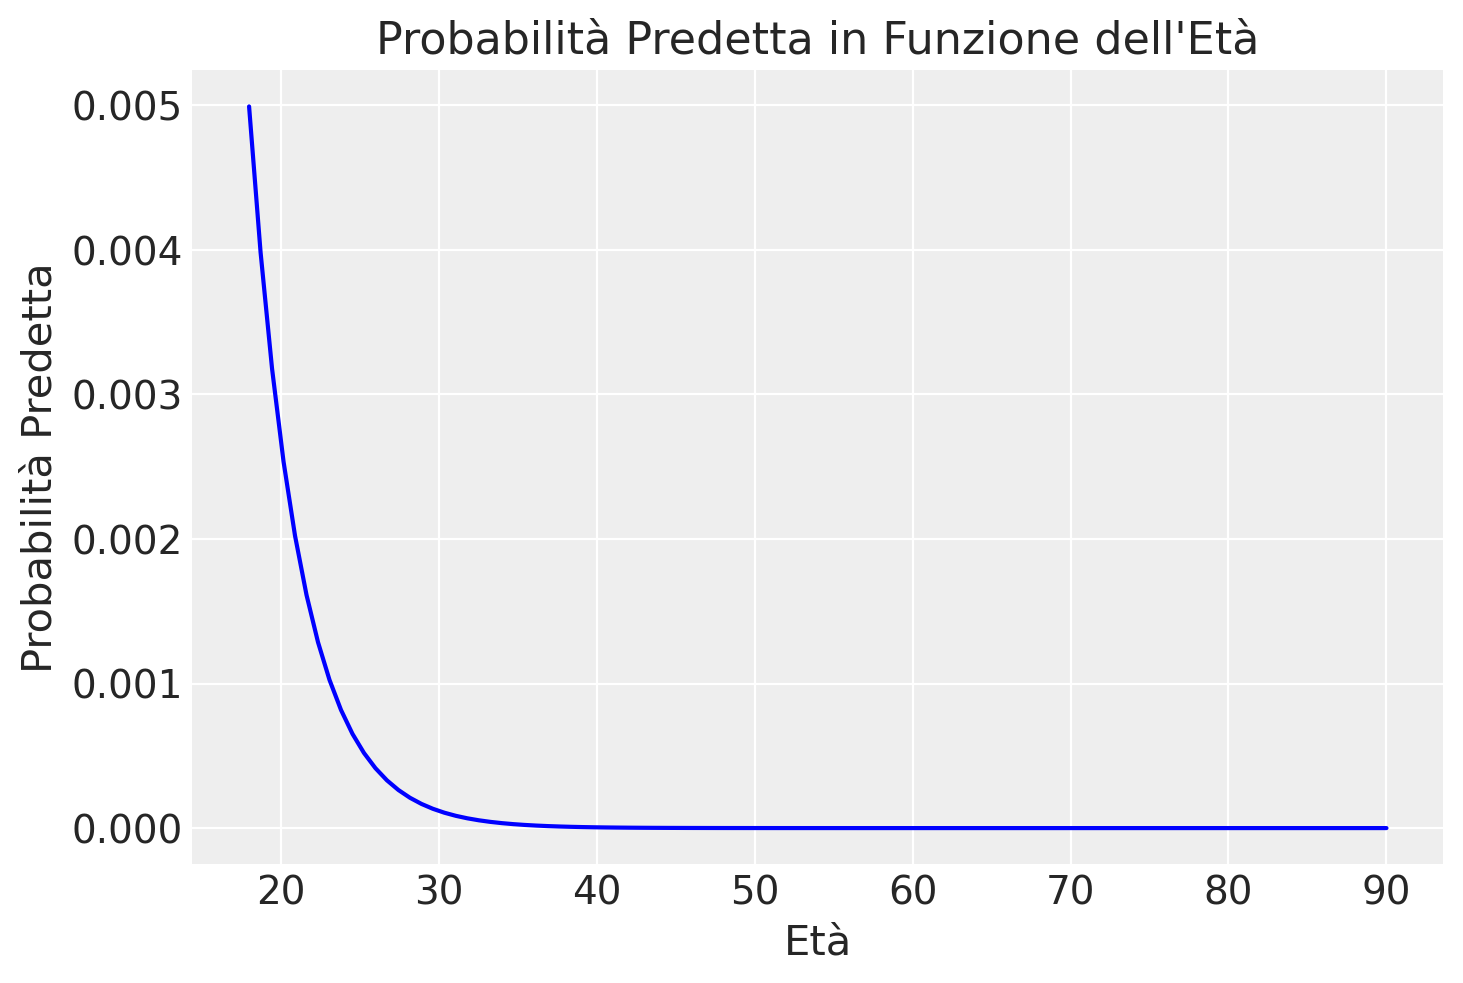

In [38]:
plt.plot(new_data['age'], new_data['prob'], linestyle='-', color='blue')  # Plot con marcatori e linea

plt.title('Probabilità Predetta in Funzione dell\'Età')  # Titolo del grafico
plt.xlabel('Età')  # Etichetta asse x
plt.ylabel('Probabilità Predetta')  # Etichetta asse y
plt.show() 

## Informazioni sull'Ambiente di Sviluppo

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanp

Last updated: Wed May 22 2024

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

cmdstanp: not installed

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
arviz     : 0.18.0
matplotlib: 3.8.4
seaborn   : 0.13.2
pandas    : 2.2.2
scipy     : 1.13.0

Watermark: 2.4.3

